# CLUSTER ANALYSIS


In my maiden project on Clulster Analysis I chose to use the RFM model for identifying clusters of Customers. I was working on the OnlineRetail dataset and it can be found here.

Having used KMeans clustering, I found intuitive clusters in the dataset but they still lacked the segmentation which I was expecting to observe. 

To play with the data further and my adamancy to see if what I am looking for truly exists in the data, I decided to take an alternative approach to the RFM analysis. The project link can be found <a url="https://github.com/dsharipriya91/ClusterAnalysis/blob/main/RFM_A_Deeper_Look.ipynb">here</a>

As I was working on the above two projects, I realised the need for data preprocessing, as the results we obtain are dependent on the data we feed into the scikit functions. Therefore in this project I have decided to:
  - Focus on the prepocessing of data
  - Compare alternate appraoches to clustering: 
     - **Perform K-Means clustering**
     - **Perform Aggomerative Hierarichal Clustering**
     - **Hybrid : Hierarichal clustering on Principal Components**
     - **Hybrid : Hierarichal KMeans Clustering**
     
     
So don’t just accept these drawbacks. Know them, so they can inform your choice of algorithms. Understand them, so you can tweak your algorithm and transform your data to solve them. And love them, because if your model could never be wrong, that means it will never be right.



### Steps Followed in this project:

* Hypothesis Building
<br><br>
* Identify Variables
    - Shortlist Variables
<br><br>
* Data Preprocessing
    - Data Imputation
    - Engineered Variables
    - Outlier Treatment
    - Grouping Operations
    - Manage Skew with Transforms
    - Feature Scaling
    - Check p-value of variables
<br><br>
* Clustering Algorithms
    - Perform K-Means clustering
    - Perform Aggomerative Hierarichal Clustering
    - Hybrid : KMeans on Principal Components
    - Hybrid : Hierarichal Clustering on Principal Components
    - Hybrid : Hierarichal KMeans Clustering
    - Gaussian Mixture Model
<br><br>
* Comparison Synopsis
<br><br>
* Conclusion
    - Takeaways
<br><br>

---

# HYPOTHESIS BUILDING

**Aim :** Classify customers based on monetary value during the given period

**Hypothesis:**
A minimum of, the following categories of customers that exist in the dataset are as follows:
  - Low value customers
  - Churned Customers
  - New Customers
  - Mid Value Customers
  - High Value Customers

# IDENTIFY VARIABLES

### Features

* Recency- No. of days since the customer's last visit
<br>

* Orders per customer - The total number of orders till date
<br>

* TotalSales - Total sum spent at the store till date
<br>

* Num_ItemTypes - Number of unique items bought till date
<br>

* Average order value - The Average order value of the customer. Total Sum/Orders per customers
<br>

In [531]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn import cluster
from sklearn.metrics import silhouette_score

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.decomposition import PCA
import statsmodels.api as sm 
pd.set_option("display.max_columns", 100)

In [141]:
df = pd.read_csv("OnlineRetail.csv", encoding="unicode_escape")
df.sample(2)

InvoiceNo StockCode                        Description  Quantity  \
446382    574895     22411  JUMBO SHOPPER VINTAGE RED PAISLEY        10   
313724    564535     23359   SET OF 12 T-LIGHTS VINTAGE DOILY        12   

             InvoiceDate  UnitPrice  CustomerID         Country  
446382  07-11-2011 14:44       2.08     16570.0  United Kingdom  
313724  25-08-2011 15:10       1.95     18075.0  United Kingdom

In [142]:
df.shape

(541909, 8)

# DATA PREPROCESSING

In [143]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

#### Change datatype of InvoiceDate feature

In [144]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

### A. Data Imputation

In [145]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Remove Rows with missing CustomerID values

In [146]:
df= df[df['CustomerID'].notna()]

In [147]:
df.shape

(406829, 8)

#### Check if Quantity feature is a positive value, else remove

In [148]:
df[df['Quantity']<=0].shape

(8905, 8)

In [149]:
df=df.loc[df['Quantity']>0]
df.shape

(397924, 8)

#### Check which countries conribute to the data

In [150]:
df['Country'].value_counts().head(5)

United Kingdom    354345
Germany             9042
France              8342
EIRE                7238
Spain               2485
Name: Country, dtype: int64

**we will consider data from UK only**

In [151]:
df = df.loc[df['Country']=='United Kingdom']
df.sample(2)

InvoiceNo StockCode                 Description  Quantity  \
419906    572862     21754    HOME BUILDING BLOCK WORD         1   
32248     539049     22112  CHOCOLATE HOT WATER BOTTLE        24   

               InvoiceDate  UnitPrice  CustomerID         Country  
419906 2011-10-26 12:48:00       6.25     16750.0  United Kingdom  
32248  2010-12-15 16:21:00       4.25     15615.0  United Kingdom

---

### B. Engineering Variables

In [152]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df.sample(2)

InvoiceNo StockCode                 Description  Quantity  \
39371     539639     22616  PACK OF 12 LONDON TISSUES          3   
132389    547663     22702    BLACK AND WHITE CAT BOWL         2   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
39371  2010-12-20 15:26:00       0.29     14083.0  United Kingdom        0.87  
132389 2011-03-24 13:16:00       2.10     16022.0  United Kingdom        4.20

In [153]:
snapshot_date = max(df['InvoiceDate'] + timedelta(days=1))
snapshot_date

Timestamp('2011-12-11 17:19:00')

### C. Grouping Operations 

In [246]:
customers = df.groupby('CustomerID').agg({
    'InvoiceDate' : lambda x: (snapshot_date - x.max()).days ,
    'InvoiceNo' : 'count',
    'TotalPrice' : 'sum',
    'Description' : 'nunique'
})

customers.rename(columns={'InvoiceDate': 'Recency',
                          'InvoiceNo': 'OrdersPerCustomer',
                         'TotalPrice' : 'TotalSales',
                         'Description' : 'TypesofItemsBought'}, inplace=True)
customers.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought
CustomerID                                                            
17787.0          65                134     1865.19                  94
16930.0          28                 54      380.55                  47

#### Compute Average Order Value

In [247]:
customers['AverageOrderValue'] = customers['TotalSales']/customers['OrdersPerCustomer']
customers.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
CustomerID                                                               
16043.0           6                 39      773.99                  30   
13536.0          11                179     3448.29                  91   

            AverageOrderValue  
CustomerID                     
16043.0             19.845897  
13536.0             19.264190

### D. Outlier Treatment

#### Check for outliers

In [248]:
customers.describe()

Recency  OrdersPerCustomer     TotalSales  TypesofItemsBought  \
count  3921.000000        3921.000000    3921.000000         3921.000000   
mean    106.554195          90.371079    1863.910113           61.049732   
std     115.037406         217.796155    7481.922217           82.401731   
min       1.000000           1.000000       0.000000            1.000000   
25%      23.000000          17.000000     300.040000           15.000000   
50%      62.000000          41.000000     651.820000           35.000000   
75%     163.000000          99.000000    1575.890000           77.000000   
max     698.000000        7847.000000  259657.300000         1778.000000   

       AverageOrderValue  
count        3921.000000  
mean           71.738338  
std          1543.783600  
min             0.000000  
25%            11.175000  
50%            17.284211  
75%            24.393182  
max         77183.600000

In [249]:
for col in customers.columns:
    percentile = customers[col].quantile([0.01,0.99]).values
    print(col, customers[customers[col]<percentile[0]][col].count(), percentile, customers[customers[col]>percentile[1]][col].count())

Recency 0 [  1.  571.8] 40
OrdersPerCustomer 0 [  1. 670.] 40
TotalSales 40 [   50.64  17280.858] 40
TypesofItemsBought 0 [  1.  355.6] 40
AverageOrderValue 40 [  2.99450853 366.708     ] 40


In [250]:
for col in customers.columns:
    percentile = customers[col].quantile([0.01,0.99]).values
    customers.loc[customers[col] < percentile[0], col]= percentile[0]
    customers.loc[customers[col] > percentile[1], col]= percentile[1]

### E. Manage Skew

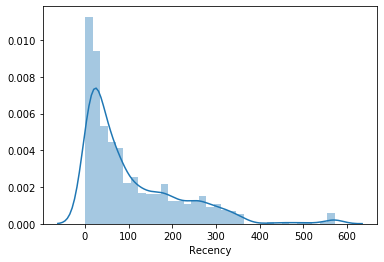

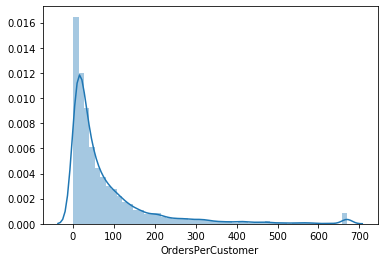

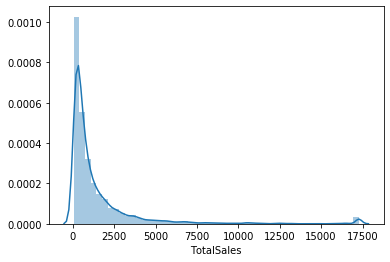

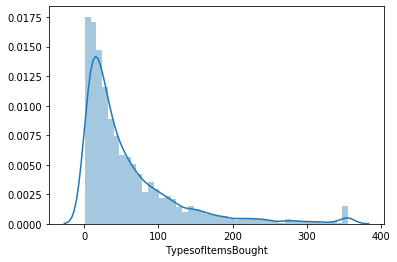

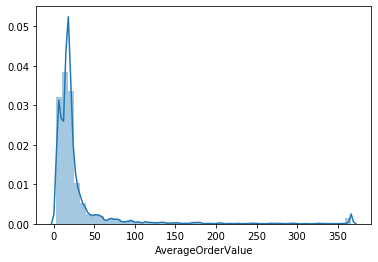

In [251]:
for i in customers.columns:
    plt.figure()
    sns.distplot(customers[i])

In [252]:
customers.skew()

Recency               1.598078
OrdersPerCustomer     2.852167
TotalSales            4.110735
TypesofItemsBought    2.209259
AverageOrderValue     5.006215
dtype: float64

**The features are heavily right skewed. Transformations can be applied to the data to rectify the skew**

In [253]:
print("Skew after Log Tranformation:")
for i in customers.columns:
    try:
        var = np.log(customers[i])
        print(" %s : %0.5f "%(i,var.skew()))
    except:
        print(i,' cannot work with log Transformation \n')

Skew after Log Tranformation:
 Recency : -0.65046 
 OrdersPerCustomer : -0.31180 
 TotalSales : 0.27252 
 TypesofItemsBought : -0.53426 
 AverageOrderValue : 0.76913 


In [254]:
print("Skew after BoxCox Tranformation:")
for i in customers.columns:
    try:
        var = stats.boxcox(customers[i])[0]
        print(" %s : %0.5f "%(i,pd.Series(var).skew()))
    except:
        print(i,' cannot work with log Transformation')

Skew after BoxCox Tranformation:
 Recency : -0.05803 
 OrdersPerCustomer : -0.00762 
 TotalSales : 0.01386 
 TypesofItemsBought : -0.01704 
 AverageOrderValue : -0.03553 


In [255]:
customers_fix = pd.DataFrame()
for i in customers.columns:
    try:
        customers_fix[i] = stats.boxcox(customers[i])[0]
    except:
        print(i,' cannot work with log Transformation')
customers_fix.head()

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
0     10.786772           0.000000    6.552729            0.000000   
1      4.413610           5.653051    5.913095            5.091918   
2      1.893010           8.630205    6.552729            9.541097   
3      4.413610           6.647765    5.900887            7.714576   
4      5.709472           4.852927    5.146147            5.539075   
...         ...                ...         ...                 ...   
3916   8.723401           2.537471    4.171925            2.762646   
3917   1.893010           2.111967    3.644117            2.268204   
3918   9.557760           2.759893    4.162910            3.026053   
3919   3.063034           8.630205    5.568880            8.893524   
3920   0.000000           5.094496    5.501470            5.669749   

      AverageOrderValue  
0              3.303302  
1              2.533486  
2              1.613024  
3              2.207272  
4              2.073929  
...                 ...  
3916           2.139772  
3917           1.891213  
3918           2.033587  
3919           0.974346  
3920           2.329490  

[3921 rows x 5 columns]

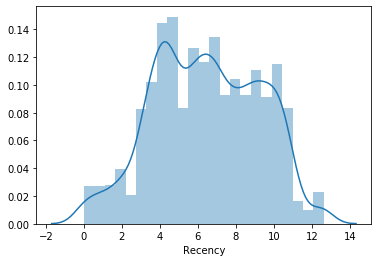

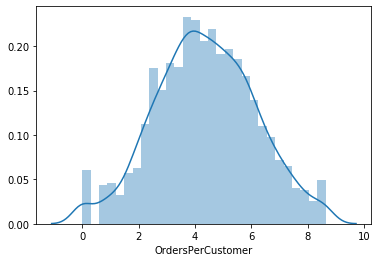

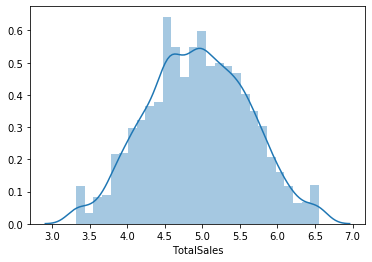

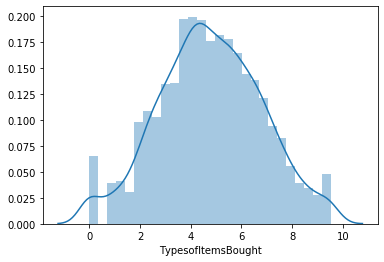

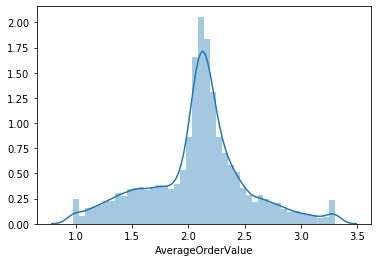

In [256]:
for i in customers_fix.columns:
    plt.figure()
    sns.distplot(customers_fix[i])

---

### F. Feature Scaling

In [257]:
customers_scaled = StandardScaler().fit_transform(customers_fix)
customers_scaled = pd.DataFrame(customers_scaled, columns=customers_fix.columns)

In [258]:
customers_scaled.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
2392 -0.990603           2.063221    1.650089            2.098267   
2630  0.170845           0.007210   -0.501587            0.114757   

      AverageOrderValue  
2392          -0.410786  
2630          -0.823422

In [259]:
customers_scaled.mean()

Recency              -6.523728e-17
OrdersPerCustomer     1.890154e-16
TotalSales           -1.002061e-16
TypesofItemsBought    6.213681e-17
AverageOrderValue     2.407607e-16
dtype: float64

In [260]:
customers_scaled.std()

Recency               1.000128
OrdersPerCustomer     1.000128
TotalSales            1.000128
TypesofItemsBought    1.000128
AverageOrderValue     1.000128
dtype: float64

### G. Observe Feature p-Values

---

# CLUSTERING

---

## 1. KMeans Clustering

#### Why KMeans

**Strengths:**
<br>
 - K-Means is the most popular clustering algorithm. It is fast for high number of datapoints, it is simple.

**Weaknesses:**
<br>
 - The user must specify the number of clusters, which might not always be easy. 
 - If the underlying clusters in the data are not naturally spherical visually, then K-Means may produce poor clusters.

[0.2503587212408206, 0.26250072639317057, 0.2638810392967594, 0.24176731052587286, 0.254117828269571]


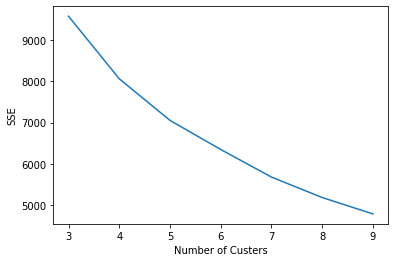

In [381]:
sse={}
silhouette=[]
for k in range(3,10):
    kmeans_model = cluster.KMeans(n_clusters=k, random_state=3)
    kmeans_model.fit_predict(customers_scaled)
    sse[k]=kmeans_model.inertia_
    silhouette.append(silhouette_score(customers_scaled, kmeans_model.labels_))

plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of Custers')
plt.ylabel('SSE')
print(silhouette[0:5])

**6 Clusters have a relatively higher silhouette score. We may choose 5 or 6, for the time being we will choose 6 clusters here since it was observed at the end that 6 clusters were apt for better segmentation**

In [588]:
kmeans_model = cluster.KMeans(n_clusters=6, random_state=3)
kmeans_model.fit_predict(customers_scaled)
kmeans_df = customers_scaled.copy(deep=True)
kmeans_df['Segment'] = kmeans_model.labels_
kmeans_df.sample()

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
150  0.292357          -1.028869    0.534062           -1.141168   

     AverageOrderValue  Segment  
150           1.985904        2

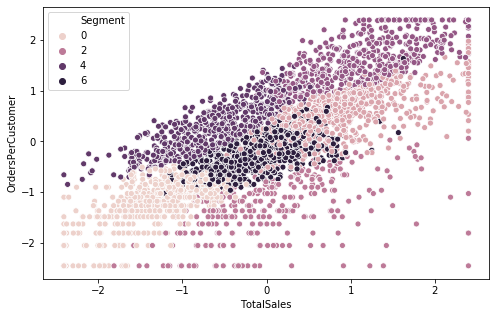

In [589]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=kmeans_df, x='TotalSales', y='OrdersPerCustomer', hue='Segment')

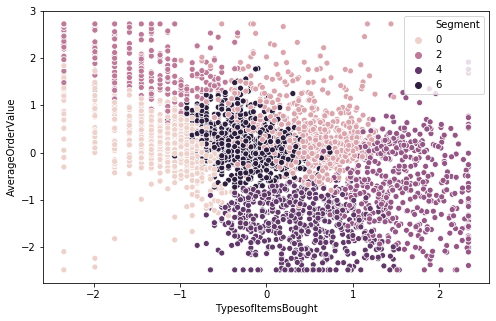

In [590]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=kmeans_df, x='TypesofItemsBought', y='AverageOrderValue', hue='Segment')

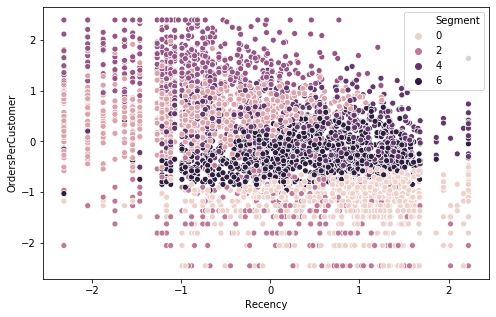

In [591]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=kmeans_df, x='Recency', y='OrdersPerCustomer', hue='Segment')

### OBSERVATIONS:
- **Upon comparison with my attempt at clustering the dataset without Outlier Treatment (not shown here), Outlier treatment has presented a better distribution of the data on the scatterplot and visually, the clusters are better identified than without an outlier treatment.**
- **Clear clusters are identifiable for all the features except slight lack of clarity for the Recency feature**



---

## 2. Agglomerative Hierarchical Clustering

#### Why Agglomerative Hierarchical Clustering

- It identifies the natural clustering in the dataset, also it identifies the hierarichal nature of clustering.
- In the previous project where I attempted RFM Analysis for segmentation, a clear clustering was not possible for the identified low-value customers.
    - A hierarichal approach could have possibly thrown light at possible sub-clusters like New customers, whose characteristics were also intrinsic in the identified low-vaue csutomers
- Agglomerative Clustering takes a bottom-up approach, and we have seen the distribution of the CustomerRetial dataset is quite tight in our dataset here.
    - We may check to see if this method is able to identify clear cluster boundaries compared to KMeans Clustering
    
<br>

**Strengths:** The main advantage of hierarchical clustering is that the clusters are not assumed to be globular. In addition, it scales well to larger datasets.

**Weaknesses:** Much like K-Means, the user must choose the number of clusters
<br><br>

In [319]:
Z = linkage(customers_scaled, 'complete')

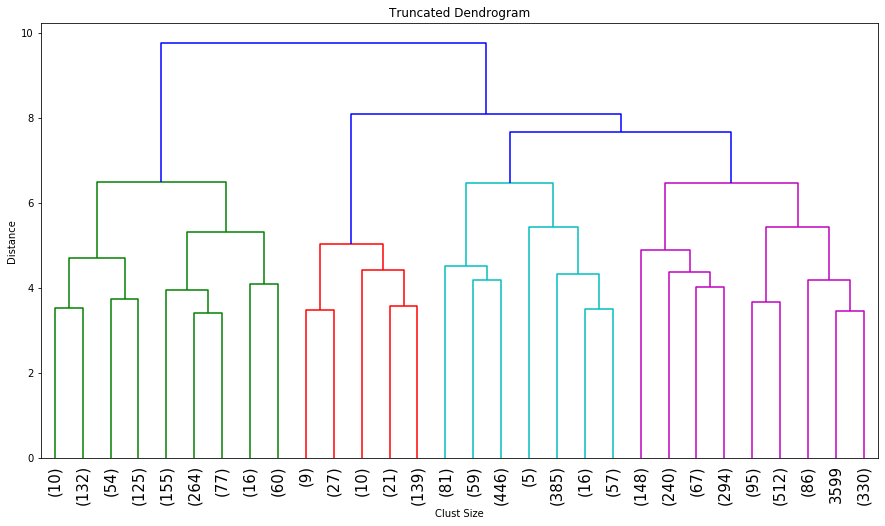

In [320]:
plt.figure(figsize=(15,8))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=15.)
plt.title("Truncated Dendrogram")
plt.xlabel('Clust Size')
plt.ylabel('Distance')
plt.show()

In [592]:
agglom_model = cluster.AgglomerativeClustering(n_clusters=6, linkage='complete')
agglom_model.fit(customers_scaled)
agglom_df = customers_scaled.copy(deep=True)
agglom_df['Segment'] = agglom_model.labels_
agglom_df.sample(2)


Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
3578 -2.047563           2.392049    1.884089            2.341457   
3539  1.671253          -2.453595   -1.929117           -2.344524   

      AverageOrderValue  Segment  
3578          -0.737983        3  
3539           1.631538        0

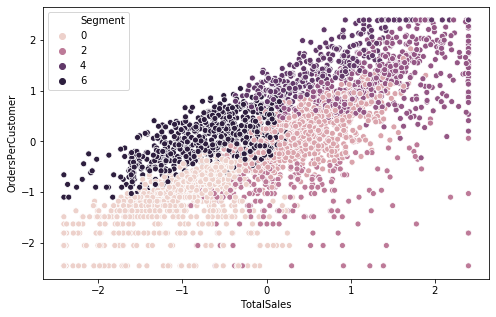

In [593]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglom_df, x='TotalSales', y='OrdersPerCustomer', hue='Segment')

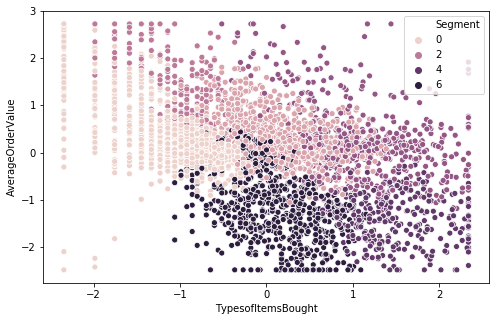

In [594]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglom_df, x='TypesofItemsBought', y='AverageOrderValue', hue='Segment')

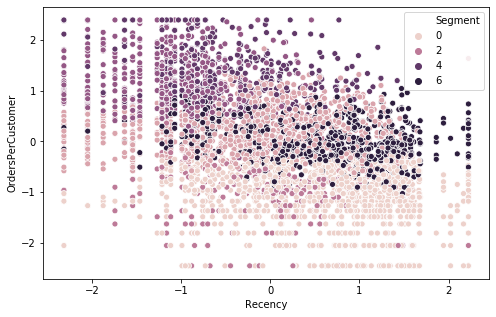

In [595]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglom_df, x='Recency', y='OrdersPerCustomer', hue='Segment')


### OBSERVATIONS:
* Complete linkage Agglomerative Clustering is used here
* The segments are divided into uneven segments and fail to show the variance across the features and therefore do not lead to intuitive insights for the big clsuters
* The cluster boundaries are not clear as well
* Agglomerative Clustering was also tried with 'Average' linkage and the results were worse than visible now
* Agglomerative clustering fails for this dataset


---

## 3. HYBRID: Hierarichal clustering on Principal Components

### Why Principal Component Analysis

<br>

- Principal Component Analysis aids in Feature reduction by identifying features in the reduced dimension over which the data shows maximum variance
- Especially when we are seeking clearer boundaries in the segmentation, features with maximum variance of the datapoints may help in identifying optimum clusters
- We can perform clustering on the identified principal components using:
    - **KMeans**
    - **Hierarichal Clustering**

In [599]:
pca = PCA(n_components=5)
pr_components = pca.fit_transform(customers_scaled)
PCA_components = pd.DataFrame(pr_components)

([<matplotlib.axis.XTick at 0x1a384e7910>,
 <a list of 5 Text xticklabel objects>)

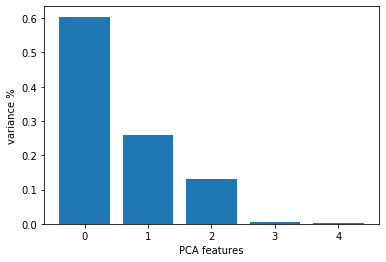

In [600]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [601]:
pca.explained_variance_ratio_

array([0.60412474, 0.25818093, 0.13062397, 0.00498207, 0.00208829])

**85% of the variance can be obtained by the first 2 principal components hence the first 2 principal components are chosen**

Text(0, 0.5, 'PCA 2')

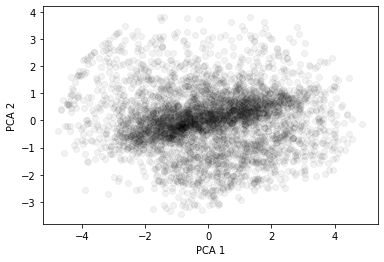

In [327]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.05, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [393]:
pca = PCA(n_components=2)
pr_components = pca.fit_transform(customers_scaled)
pcs = pd.DataFrame(pr_components)
pcs.sample(5)

0         1
3664  1.602157  0.451865
165  -1.410324  0.844861
1220 -1.200485 -0.130460
416   1.915239  0.310360
3244 -0.765304  1.904871

### KMeans Clustering on PCA

AIM:
- KMeans clulstering was able to identify clusters but the segment boundaries were not very well seperated or clear
- The Recency Variable was also not able to provide better clusters
- We may check whether PCA offers some improvement to the above problems

[0.4388252796697476, 0.47460869878585826, 0.49431932539325485, 0.535574450568365, 0.5123147131128463]


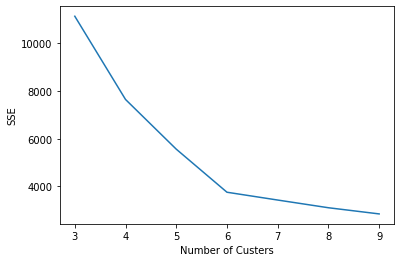

In [551]:
sse={}
silhouette=[]
for k in range(3,10):
    kmeanspca_model = cluster.KMeans(n_clusters=k, random_state=3)
    kmeanspca_model.fit_predict(pcs)
    sse[k]=kmeanspca_model.inertia_
    silhouette.append(silhouette_score(pcs, kmeanspca_model.labels_))

plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Number of Custers')
plt.ylabel('SSE')
print(silhouette[0:5])



**Revision: 6 Clusters shows the highest sihouette score, we will stick to 6 , as opposed to the hypothesis as an analysis till the end showed that 6 clsuters offer better segmentation**

In [602]:
kmeanspca_model = cluster.KMeans(n_clusters=6, random_state=3)
kmeanspca_model.fit_predict(pcs)
pcs['Segment'] = kmeanspca_model.labels_
pcs.sample(2)

0         1  Segment
3143 -1.221951  0.617715        4
33    1.783537  0.174061        3

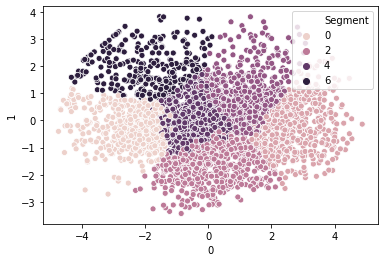

In [603]:
sns.scatterplot(data=pcs, x=0,y=1, hue='Segment')

In [604]:
### Join PCA segments and Customers df
kmeanspca_df = customers_scaled.copy(deep=True)
kmeanspca_df['Segment'] = kmeanspca_model.labels_
kmeanspca_df.sample(5)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
880  -1.214272           0.782360    2.077294            0.485856   
3136 -2.314222          -0.198714    0.776617           -0.557283   
2327  1.609824          -2.453595   -1.947364           -2.344524   
2036 -0.332625          -0.175645    0.043604           -0.123085   
740   0.577755           1.663656    1.231132            1.855336   

      AverageOrderValue  Segment  
880            1.762374        3  
3136           1.258792        3  
2327           1.616159        0  
2036           0.283059        4  
740           -0.610697        1

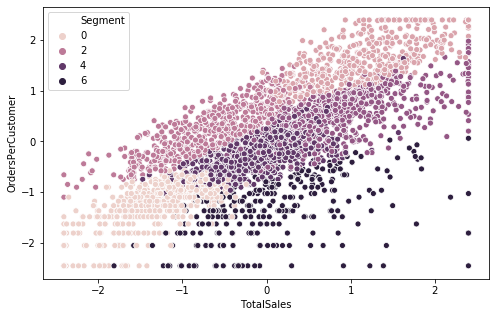

In [605]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=kmeanspca_df, x='TotalSales', y='OrdersPerCustomer', hue='Segment')

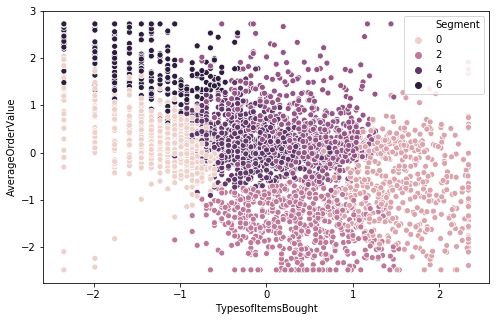

In [606]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=kmeanspca_df, x='TypesofItemsBought', y='AverageOrderValue', hue='Segment')

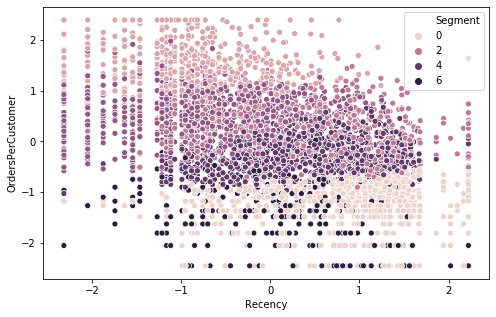

In [607]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=kmeanspca_df, x='Recency', y='OrdersPerCustomer', hue='Segment')

#### OBSERVATIONS:

- **There doesn't appear to be much improvement over the KMeans clustering performed earlier**
- **Recency variable shows relatively bad clustering here compared to the KMeans appraoach**

### Hierarichal clustering on Principal Components

AIM:
- To check whether PCA offers improvement on the problem of overcrowding clusters

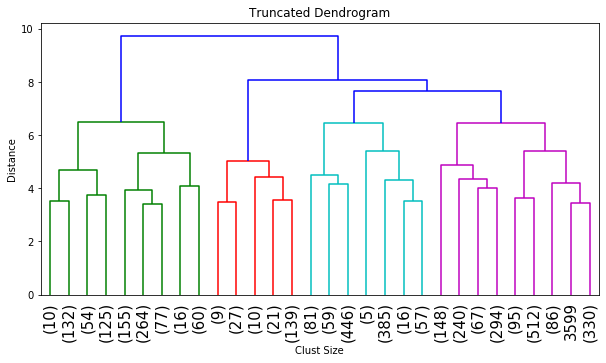

In [609]:
Z = linkage(customers_scaled, 'complete')

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=15.)
plt.title("Truncated Dendrogram")
plt.xlabel('Clust Size')
plt.ylabel('Distance')
plt.show()


In [610]:
agglompca_model = cluster.AgglomerativeClustering(n_clusters=6, linkage='complete')
agglompca_model.fit(pcs)
agglompca_df = customers_scaled.copy(deep=True)
agglompca_df['Segment'] = agglompca_model.labels_
agglompca_df.sample(2)



Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
3032 -0.154474           0.712405    0.792778            0.945254   
3832 -0.029679          -1.100180   -1.033449           -1.060812   

      AverageOrderValue  Segment  
3032           0.050485        5  
3832           0.376768        3

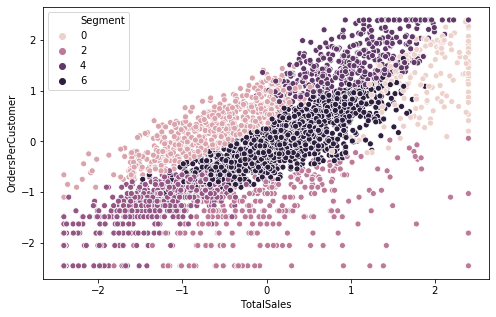

In [611]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglompca_df, x='TotalSales', y='OrdersPerCustomer', hue='Segment')

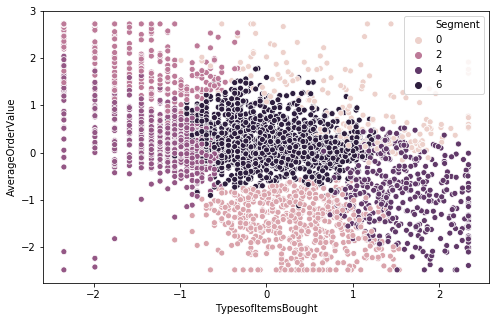

In [612]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglompca_df, x='TypesofItemsBought', y='AverageOrderValue', hue='Segment')


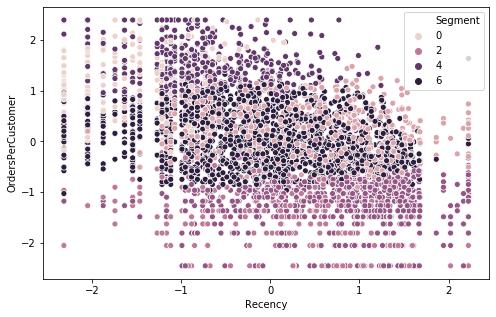

In [613]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglompca_df, x='Recency', y='OrdersPerCustomer', hue='Segment')


### OBSERVATIONS:
* The problem of uneven cluster sizes has not been resolved with hierarichal clustering

## 4. Hierarichal KMeans Clustering

#### Why Hierarichal KMeans Clustering
- Results of KMeans clustering is affected  by the intial centroid which is chosen.
- Hierarichal Clustering identifies the natural clustering in the dataset
- Identifying the natural clustering in the dataset can provide us an insight into identifying better initial centroids for KMeans clustering

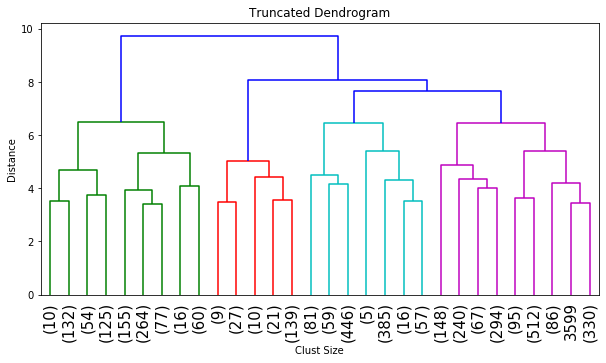

In [615]:
Z = linkage(customers_scaled, 'complete')
plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=15.)
plt.title("Truncated Dendrogram")
plt.xlabel('Clust Size')
plt.ylabel('Distance')
plt.show()

In [616]:
agglokm_model = cluster.AgglomerativeClustering(n_clusters=6, linkage='complete')
agglokm_model.fit(customers_scaled)
agglokm_df = customers_scaled.copy(deep=True)
agglokm_df['Segment'] = agglokm_model.labels_
agglokm_df.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
454   1.312327          -2.052991   -0.081596           -2.344524   
1894 -0.952841           0.679479    2.113408            0.234710   

      AverageOrderValue  Segment  
454            2.592539        0  
1894           1.907158        3

In [617]:
np.array(agglokm_df.groupby('Segment').mean())

array([[ 0.57176894, -1.09849387, -1.01269807, -1.07170111,  0.36350774],
       [-0.21094023,  0.22080325,  0.47068198,  0.21854722,  0.29570153],
       [-0.16842373, -1.01336156,  0.34008782, -1.16270172,  1.65286779],
       [-1.04459904,  1.20657619,  1.36440899,  1.10102038,  0.28222824],
       [-0.45591929,  1.40464667,  0.59440755,  1.46772533, -1.40770507],
       [ 0.52706703, -0.00812168, -0.61543782,  0.05208969, -0.98020024]])

In [618]:
centroid_arr = np.array(agglokm_df.groupby('Segment').mean())
centroid_arr 

array([[ 0.57176894, -1.09849387, -1.01269807, -1.07170111,  0.36350774],
       [-0.21094023,  0.22080325,  0.47068198,  0.21854722,  0.29570153],
       [-0.16842373, -1.01336156,  0.34008782, -1.16270172,  1.65286779],
       [-1.04459904,  1.20657619,  1.36440899,  1.10102038,  0.28222824],
       [-0.45591929,  1.40464667,  0.59440755,  1.46772533, -1.40770507],
       [ 0.52706703, -0.00812168, -0.61543782,  0.05208969, -0.98020024]])

- **Initialise the centroid for KMeans clustering by taking the mean of the segments obtained by Hierarichal clustering**

- **6 KMeans clusters seem to be dividing the semgents well, therefore we choose 5 clusters for hierarichal clsters as well**

In [619]:
agglokm_model = cluster.KMeans(n_clusters=6, init=centroid_arr, n_init=1, random_state=3)
agglokm_model.fit_predict(customers_scaled)
agglokm_df = customers_scaled.copy(deep=True)
agglokm_df['Segment'] = agglokm_model.labels_
agglokm_df.sample()

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
123 -0.701791          -0.222454   -0.216781           -0.123085   

     AverageOrderValue  Segment  
123          -0.004735        1

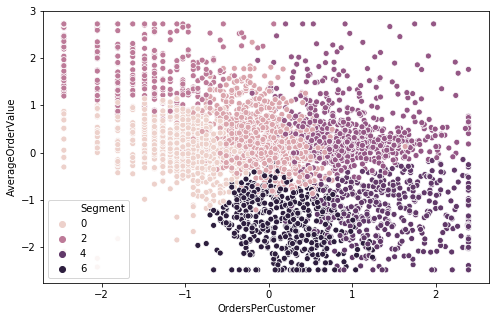

In [620]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglokm_df, x='OrdersPerCustomer', y='AverageOrderValue', hue='Segment')

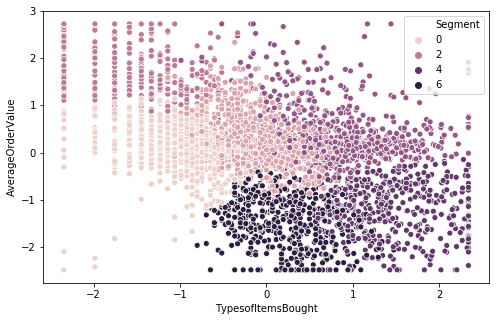

In [621]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglokm_df, x='TypesofItemsBought', y='AverageOrderValue', hue='Segment')

In [622]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=agglokm_df, x='Recency', y='AverageOrderValue', hue='Segment')

## 5. Gaussian Mixture Model

**Why GMM**

- **A Soft Clustering Technique**

In [623]:
from sklearn.mixture import GaussianMixture
gmm_model = GaussianMixture(n_components=6)
gmm_model.fit(customers_scaled)
gmm_pred = gmm_model.predict(customers_scaled)
gmm_df = customers_scaled.copy(deep=True)
gmm_df['Segment'] = gmm_pred

In [624]:
gmm_df.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
3704 -0.729274          -0.442619   -0.019419           -0.475939   
1677 -0.990603          -0.580701   -0.392791           -0.600864   

      AverageOrderValue  Segment  
3704           0.601612        3  
1677           0.332459        3

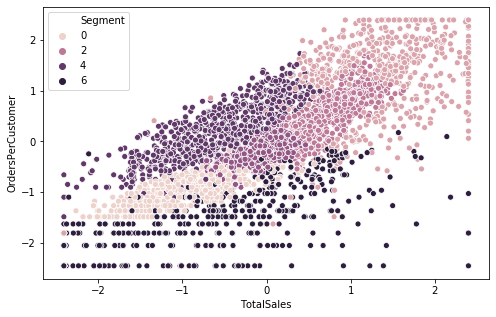

In [625]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=gmm_df, x='TotalSales', y='OrdersPerCustomer', hue='Segment')

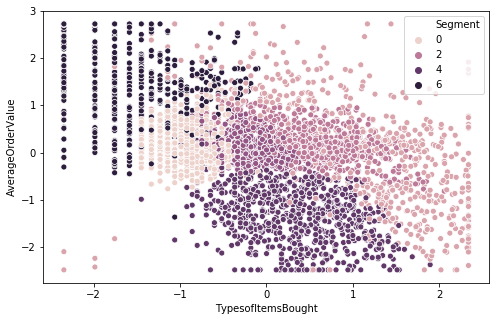

In [626]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=gmm_df, x='TypesofItemsBought', y='AverageOrderValue', hue='Segment')

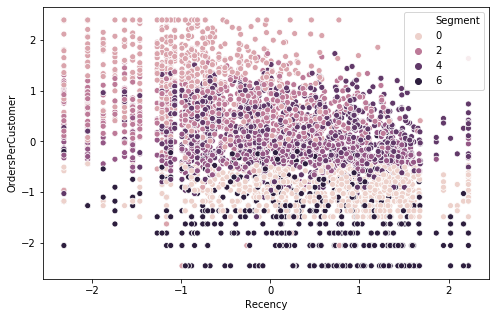

In [627]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=gmm_df, x='Recency', y='OrdersPerCustomer', hue='Segment')

#### OBSERVATIONS:

* Compared to the KMeans Clustering method, here the clusters seem to be unevenly sized

---

# COMPARISON SYNOPSIS

- KMeans algorithm has created realtively better clustering than Hierarichal Clustering has created.
- Hierarichal clustering identifies the natural clusters that exist in the dataset, but here, hierarichal clustering returned quite unevenly distributed data cross the identified segments. It is possiby indicative of a homegeneity in the data points. Increasing the number of clusters to define subclusters
- For the above reason it was wise to explore more options to arrive at better segmentation, therefore hybrid approaches were undertaken

Text(0.5, 1.0, 'GMM Clustering')

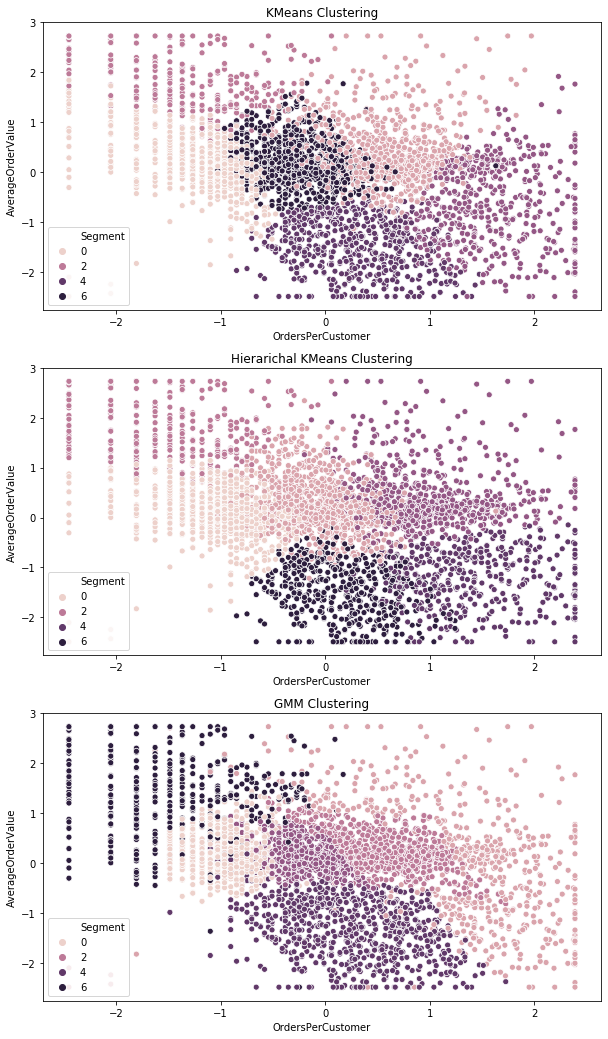

In [636]:

f, axes =plt.subplots(3,1, figsize=(10,18))
sns.scatterplot(data=kmeans_df, x='OrdersPerCustomer', y='AverageOrderValue', hue='Segment', ax=axes[0])
sns.scatterplot(data=agglokm_df, x='OrdersPerCustomer', y='AverageOrderValue', hue='Segment', ax=axes[1])
sns.scatterplot(data=gmm_df, x='OrdersPerCustomer', y='AverageOrderValue', hue='Segment', ax=axes[2])

axes[0].set_title('KMeans Clustering')
axes[1].set_title('Hierarichal KMeans Clustering')
axes[2].set_title('GMM Clustering')

### Descriptive Statistics for the KMeans Segments

In [629]:
customers_new = customers.copy(deep=True)
customers_new = pd.concat([customers_new.reset_index(drop=True), kmeans_df['Segment']],axis=1)
customers_new.rename(columns={'Segment': 'KMeansSegment'}, inplace=True)
customers_new.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
226     198.0                1.0     3096.00                 1.0   
1925     86.0               10.0      412.01                10.0   

      AverageOrderValue  KMeansSegment  
226             366.708              2  
1925             41.201              2

In [630]:
customers_new.groupby('KMeansSegment').describe()

Recency                                                    \
                count        mean         std  min    25%    50%    75%   
KMeansSegment                                                             
0               660.0  197.875758  134.897746  1.0  80.75  184.0  278.0   
1               887.0   35.770011   38.452972  1.0  12.00   23.0   47.0   
2               279.0  114.371326  106.953786  1.0  29.00   83.0  163.0   
3               520.0   30.311538   33.637348  1.0  11.00   19.0   37.0   
4               562.0  133.487900  118.925419  1.0  39.00   96.0  193.5   
5              1013.0  127.206515   94.143114  1.0  53.00   99.0  188.0   

                     OrdersPerCustomer                                        \
                 max             count        mean         std   min     25%   
KMeansSegment                                                                  
0              571.8             660.0    8.843939    4.513162   1.0    6.00   
1              246.0             887.0   93.305524   49.545316  19.0   59.00   
2              571.8             279.0    8.698925    7.703290   1.0    3.00   
3              244.0             520.0  310.528846  156.618503  99.0  194.00   
4              571.8             562.0   70.784698   41.893740  13.0   38.25   
5              571.8            1013.0   31.870681   17.368537  10.0   20.00   

                                    TotalSales                            \
                 50%     75%    max      count         mean          std   
KMeansSegment                                                              
0                9.0   12.00   22.0      660.0   168.379758    81.101383   
1               84.0  117.00  431.0      887.0  2687.163665  3134.944467   
2                6.0   12.00   45.0      279.0  1422.049391  2598.447365   
3              264.0  385.75  670.0      520.0  4012.026519  3621.689053   
4               60.0   93.75  249.0      562.0   396.162527   238.644173   
5               28.0   39.00  297.0     1013.0   627.776874   406.565101   

                                                                 \
                  min       25%       50%        75%        max   
KMeansSegment                                                     
0               50.64   108.470   155.535   215.9150    489.600   
1              355.56  1161.650  1786.790  2700.1450  17280.858   
2               90.48   357.885   640.140  1285.1750  17280.858   
3              562.90  1593.335  2862.870  4883.8400  17280.858   
4               50.64   204.265   342.955   555.2575   1319.190   
5              168.24   365.270   519.680   765.3200   5391.210   

              TypesofItemsBought                                              \
                           count        mean        std   min     25%    50%   
KMeansSegment                                                                  
0                          660.0    8.662121   4.461886   1.0    5.00    9.0   
1                          887.0   66.861330  28.423593   9.0   45.00   65.0   
2                          279.0    6.523297   5.229138   1.0    2.00    5.0   
3                          520.0  195.228846  76.933374  75.0  138.75  173.0   
4                          562.0   61.537367  33.430581  13.0   35.00   54.5   
5                         1013.0   28.801579  13.346593   8.0   19.00   26.0   

                            AverageOrderValue                          \
                 75%    max             count        mean         std   
KMeansSegment                                                           
0               12.0   22.0             660.0   22.470474   14.073082   
1               87.0  167.0             887.0   30.844916   39.439721   
2                9.0   24.0             279.0  148.891251  109.216858   
3              239.5  355.6             520.0   12.781387   10.197909   
4               79.0  177.0             562.0    5.840026    1.901800   
5               35.0  1

### Descriptive Statistics for the Hierarichal KMeans Segments

In [631]:
customers_new = pd.concat([customers_new.reset_index(drop=True), agglokm_df['Segment']],axis=1)
customers_new.rename(columns={'Segment': 'AggloKMeansSegment'}, inplace=True)
customers_new.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
2403    170.0               58.0     1037.59                45.0   
1128     12.0              206.0     1058.06               112.0   

      AverageOrderValue  KMeansSegment  AggloKMeansSegment  
2403          17.889483              5                   1  
1128           5.136214              3                   4

In [632]:
customers_new.groupby('AggloKMeansSegment').describe()

Recency                                                     \
                     count        mean         std  min    25%    50%     75%   
AggloKMeansSegment                                                              
0                    870.0  191.354483  124.784626  1.0  81.00  183.0  268.00   
1                   1088.0   83.589706   76.241473  1.0  26.00   61.0  116.25   
2                    302.0  135.477483  119.806227  1.0  45.00   98.0  198.75   
3                    765.0   32.273203   36.687657  1.0  11.00   20.0   41.00   
4                    426.0   36.669014   38.980971  1.0  14.00   23.0   46.00   
5                    470.0  160.063404  124.131746  5.0  55.25  139.0  243.75   

                          OrdersPerCustomer                                \
                      max             count        mean         std   min   
AggloKMeansSegment                                                          
0                   571.8             870.0   12.356322    6.430074   1.0   
1                   571.8            1088.0   41.462316   20.583897   9.0   
2                   571.8             302.0    6.774834    6.393697   1.0   
3                   246.0             765.0  160.861438  112.253321  32.0   
4                   236.0             426.0  273.464789  169.311186  54.0   
5                   571.8             470.0   57.670213   31.166924  13.0   

                                                 TotalSales               \
                       25%    50%     75%    max      count         mean   
AggloKMeansSegment                                                         
0                     8.00   11.0   17.00   31.0      870.0   225.910748   
1                    27.00   37.0   52.00  297.0     1088.0   884.871803   
2                     2.00    5.0    9.75   45.0      302.0  1204.266689   
3                    90.00  123.0  189.00  670.0      765.0  4221.168940   
4                   144.25  215.0  349.25  670.0      426.0  2184.324394   
5                    33.00   51.0   74.75  191.0      470.0   326.689043   

                                                                        \
                            std     min        25%       50%       75%   
AggloKMeansSegment                                                       
0                    117.787988   50.64   133.6800   205.500   310.365   
1                    574.017420  168.24   526.5175   740.860  1071.270   
2                   2509.978608   50.64   256.8400   515.740  1017.640   
3                   3951.234229  732.07  1827.8000  2735.370  4748.520   
4                   2266.314411  302.10   885.6925  1481.180  2621.905   
5                    183.765715   50.64   187.9750   286.265   411.130   

                              TypesofItemsBought                               \
                          max              count        mean        std   min   
AggloKMeansSegment                                                              
0                     755.750              870.0   12.049425   6.293994   1.0   
1                    6463.840             1088.0   35.786765  16.080883   6.0   
2                   17280.858              302.0    5.245033   4.401701   1.0   
3                   17280.858              765.0  104.709804  59.853411  10.0   
4                   17280.858              426.0  180.561033  84.349800  53.0   
5                    1079.340              470.0   51.270213  25.645387  13.0   

                                                AverageOrderValue              \
                      25%    50%     75%    max             count        mean   
AggloKMeansSegment                                                              
0                     7.0   11.0   16.00   30.0             870.0   19.327636   
1                    24.0   32.0   45.00  107.0            1088.0   22.866610   
2                     2.0    4.0    8.00   24.0             302.0  141.579159   
3                    66.0  

### Descriptive Statistics for the Gaussian Mixture Model

In [633]:
customers_new = pd.concat([customers_new.reset_index(drop=True), gmm_df['Segment']],axis=1)
customers_new.rename(columns={'Segment': 'GMMSegment'}, inplace=True)
customers_new.sample(2)

Recency  OrdersPerCustomer  TotalSales  TypesofItemsBought  \
3904    142.0               13.0      149.48                13.0   
149      24.0               45.0      661.32                40.0   

      AverageOrderValue  KMeansSegment  AggloKMeansSegment  GMMSegment  
3904          11.498462              0                   0           0  
149           14.696000              1                   1           3

In [634]:
customers_new.groupby('GMMSegment').describe()

Recency                                                           \
             count        mean         std  min    25%    50%    75%    max   
GMMSegment                                                                    
0            694.0  167.689625  127.996340  1.0  59.00  152.5  254.0  571.8   
1            593.0   32.584823   44.176095  1.0  11.00   19.0   40.0  571.8   
2            787.0   57.228717   58.608187  1.0  18.00   34.0   79.0  355.0   
3            649.0  114.573806   98.776480  1.0  36.00   80.0  175.0  571.8   
4            754.0  123.045093  115.085850  1.0  27.25   81.5  188.0  571.8   
5            444.0  148.660360  130.198038  1.0  43.50  115.5  221.0  571.8   

           OrdersPerCustomer                                              \
                       count        mean         std   min    25%    50%   
GMMSegment                                                                 
0                      694.0   12.626801    5.003367   5.0    8.0   12.0   
1                      593.0  269.686341  178.789188   1.0  134.0  237.0   
2                      787.0   98.687421   47.699509  20.0   64.0   88.0   
3                      649.0   33.718028   10.480979  12.0   26.0   31.0   
4                      754.0   70.001326   49.049897   5.0   31.0   57.0   
5                      444.0    7.993243    8.228259   1.0    2.0    5.0   

                         TotalSales                                    \
              75%    max      count         mean          std     min   
GMMSegment                                                              
0            16.0   33.0      694.0   257.207033   149.941062   58.08   
1           364.0  670.0      593.0  5176.533066  4443.335294   50.64   
2           123.0  330.0      787.0  1874.162288   784.540568  695.42   
3            41.0   75.0      649.0   612.532114   183.453883  275.28   
4            98.0  330.0      754.0   425.310199   277.593977   50.64   
5            11.0   52.0      444.0   889.330973  1983.091752   50.64   

                                                      TypesofItemsBought  \
                  25%       50%        75%        max              count   
GMMSegment                                                                 
0            152.7225   228.915   318.8075   1304.040              694.0   
1           1960.1100  3877.520  6328.0500  17280.858              593.0   
2           1237.0350  1680.720  2357.1700   5398.300              787.0   
3            462.9500   601.270   745.0600   1143.270              649.0   
4            205.6950   346.215   605.4500   1451.280              754.0   
5            135.6375   356.425   842.7375  17280.858              444.0   

                                                                     \
                  mean         std   min   25%    50%    75%    max   
GMMSegment                                                            
0            12.623919    4.992757   5.0   8.0   12.0   16.0   32.0   
1           156.485666  102.411931   1.0  66.0  148.0  227.0  355.6   
2            78.655654   37.389050  14.0  53.0   71.0   98.0  281.0   
3            31.255778   10.115959  10.0  24.0   29.0   38.0   71.0   
4            60.259947   38.691188   5.0  29.0   51.0   83.0  244.0   
5             6.626126    6.604249   1.0   2.0    4.0    9.0   35.0   

           AverageOrderValue                                                \
                       count        mean         std        min        25%   
GMMSegment                                                                   
0                      694.0   20.499515    7.922706   9.000000  15.454375   
1                      593.0   35.888810   57.368860   2.994509   7.888101   
2                      787.0   20.507459    6.951739   8.679364  16.220895   
3                      649.0   18.703860    4.687324  10.917600  15.630286   
4                      754.0    6.886025    3.125133   2.994509   4.619004   
5      

#### OBSERVATIONS: 
* KMeans Clustering has a better overall result under segmentation as it appears to visually show lesser intra segment variation and more inter-segement variance

# CONCLUSION

### KMeans clustering is a popular clustering method. In this project, a stand-alone clustering method performed better than attempts to optimize is futher.



### TakeAways:
 - This project gave me an opportunity to explore Hybrid methods of approaching clustering
 - **Outlier Treatment:** Compared to my first attempt at clustering the same dataset, I included Outlier Treatment in this project. The results are quite visibly different and yieded better segmentation
 - Key takeaway was: 

**Identify the shortcomings of an agorithm that works and explore how it works with other methods that may overcome the shortcomings**
    